In [1]:
%pip -q install mlflow boto3 awscli

Note: you may need to restart the kernel to use updated packages.


## Import Dependencies

In [2]:
# Data manipulation and analysis
import numpy as np
import pandas as pd
import re
from collections import Counter
import os

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix,
    precision_recall_fscore_support
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# MLflow for experiment tracking
import mlflow
import mlflow.sklearn

# AWS Services (optional - for S3 artifact storage)
import boto3

# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [3]:

df = pd.read_csv('https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv')
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [4]:

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df = df[~(df['clean_comment'].str.strip() == '')]

In [5]:
# Define the preprocessing function
def preprocess_comment(comment):
    # Convert to lowercase
    comment = comment.lower()

    # Remove trailing and leading whitespaces
    comment = comment.strip()

    # Remove newline characters
    comment = re.sub(r'\n', ' ', comment)

    # Remove non-alphanumeric characters, except punctuation
    comment = re.sub(r'[^A-Za-z0-9\s!?.,]', '', comment)

    # Remove stopwords but retain important ones for sentiment analysis
    stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}
    comment = ' '.join([word for word in comment.split() if word not in stop_words])

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    comment = ' '.join([lemmatizer.lemmatize(word) for word in comment.split()])

    return comment

In [6]:

# Apply the preprocessing function to the 'clean_comment' column
df['clean_comment'] = df['clean_comment'].apply(preprocess_comment)

df.head()
     

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1


In [7]:

# Step 1: Vectorize the comments using Bag of Words (CountVectorizer)
vectorizer = CountVectorizer(max_features=10000)  # Bag of Words model with a limit of 1000 features

X = vectorizer.fit_transform(df['clean_comment']).toarray()
y = df['category']  # Assuming 'sentiment' is the target variable (0 or 1 for binary classification)

In [8]:
X.shape


(36793, 10000)

In [9]:
y.shape

(36793,)

In [10]:
mlflow.set_tracking_uri("http://ec2-54-211-18-166.compute-1.amazonaws.com:5000/")
mlflow.set_experiment("Random Forest Baseline")

<Experiment: artifact_location='s3://mlfow-bucket-2025/612284321741813121', creation_time=1762865221147, experiment_id='612284321741813121', last_update_time=1762865221147, lifecycle_stage='active', name='Random Forest Baseline', tags={}>

2025/11/11 18:34:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/11 18:34:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/11/11 18:34:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest_Baseline_TrainTestSplit at: http://ec2-54-211-18-166.compute-1.amazonaws.com:5000/#/experiments/612284321741813121/runs/82471feaf3894e4782e6bb96365e203f
🧪 View experiment at: http://ec2-54-211-18-166.compute-1.amazonaws.com:5000/#/experiments/612284321741813121
Accuracy: 0.6511754314444897
Accuracy: 0.6511754314444897


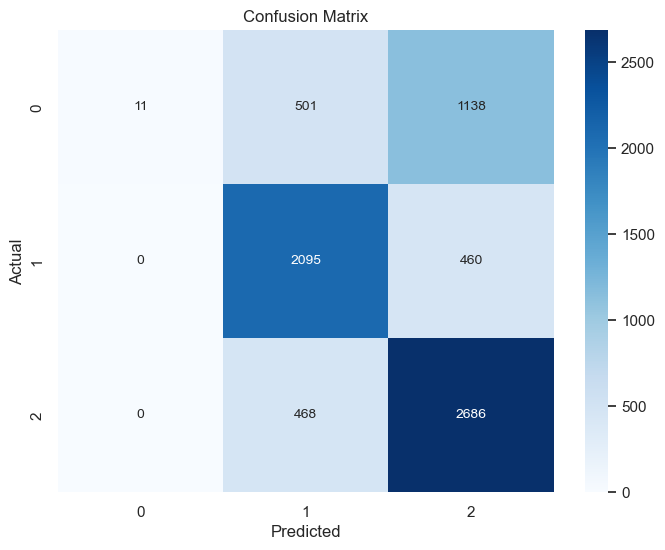

In [11]:
# Step 1: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Define and train a Random Forest baseline model using a simple train-test split
with mlflow.start_run() as run:
    # Log a description for the run
    mlflow.set_tag("mlflow.runName", "RandomForest_Baseline_TrainTestSplit")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "RandomForestClassifier")

    # Add a description
    mlflow.set_tag("description", "Baseline RandomForest model for sentiment analysis using Bag of Words (BoW) with a simple train-test split")

    # Log parameters for the vectorizer
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("vectorizer_max_features", vectorizer.max_features)

    # Log Random Forest parameters
    n_estimators = 200
    max_depth = 15

    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)

    # Initialize and train the model
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Log metrics for each class and accuracy
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):  # For precision, recall, f1-score, etc.
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    # Confusion matrix plot
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Save and log the confusion matrix plot
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Log the Random Forest model
    mlflow.sklearn.log_model(model, "random_forest_model")

    # Optionally log the dataset itself (if it's small enough)
    df.to_csv("dataset.csv", index=False)
    # Log the dataset file that was just saved (use the relative/local path)
    mlflow.log_artifact("dataset.csv")

# Display final accuracy
print(f"Accuracy: {accuracy}")
     

In [12]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      0.01      0.01      1650
           0       0.68      0.82      0.75      2555
           1       0.63      0.85      0.72      3154

    accuracy                           0.65      7359
   macro avg       0.77      0.56      0.49      7359
weighted avg       0.73      0.65      0.57      7359

